**Validate the columns with nan percentage less than 6 and if all of them belong to same row then drop row.**

**Drop columns with more than 47% of nan values.**

**Add replace nan with mean value in columns where nan % is between 5.53 to 47 in continuous column and similarly mode for categorical column.**

**Categorical columns are encoded with one hot encoding and ordinal encoding.**

**Merged derived columns.**

**While doing one hot encoding inside column we considered 5 categories and further from 5 was added and named as other.**

**kmeans clustering was done.** 

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
import pickle 
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_pickle('/content/gdrive/MyDrive/Colab Notebooks/merged_df.pkl')

In [ ]:
df_copy= df.copy()


In [ ]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)
pd.set_option("display.max_colwidth",None)
pd.options.display.float_format = '{:,.3f}'.format

## No of Previous Applications

In [ ]:
df_copy['No_of_PreviousApplications'] = df_copy['SK_ID_PREV_list'].str.len()

## Credit to Income

In [ ]:
df_copy['Credit_to_Income'] = df_copy['AMT_CREDIT']/df_copy['AMT_INCOME_TOTAL']*100

## Annuity to Income

In [ ]:
df_copy['Annuity_to_Income'] = df_copy['AMT_ANNUITY']/df_copy['AMT_INCOME_TOTAL']*100

## Goods Price to Income

In [ ]:
df_copy['Goods_to_Income'] = df_copy['AMT_GOODS_PRICE']/df_copy['AMT_INCOME_TOTAL']*100

## No of Documents submitted

In [ ]:
df_copy['No_of_DocumentsSubmitted'] = df_copy.iloc[:,96:116].sum(axis=1)

## Source Score Average

In [ ]:
df_copy['EXT_SCORES_AVG'] = (df_copy[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].sum(axis=1))/3

## Source Score Sum

In [ ]:
df_copy['EXT_SCORES_SUM'] = df_copy[['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']].sum(axis=1)

In [ ]:
#function to calculate corelation
from scipy.stats import pearsonr
def relation(column):
  corr, _ = pearsonr(df_copy["TARGET"], df_copy[column])
  return print('Pearsons correlation: %.3f' % corr)

flag car, flag house

converted n=0 y=1 and added and added values.

gender,house,car

In [ ]:
df_copy["car_house_gender"]=df_copy["FLAG_OWN_CAR"]+df_copy["FLAG_OWN_REALTY"]+df_copy["CODE_GENDER"]
df_copy["car_house_gender"]=df_copy["car_house_gender"].replace({'NYM':'011','NNF':'000','YYM':'111','NYF':'010','YYF':'110','YNM':'101','NNM':'001','YNF':'100','YYXNA':'112','NYXNA':'012'})
df_copy["car_house_gender"]=df_copy["car_house_gender"].astype(int)
relation("car_house_gender")

Pearsons correlation: -0.022


credit/income

In [ ]:
df_copy["income_vs_credit"]=round(df_copy["AMT_CREDIT"]/df_copy["AMT_INCOME_TOTAL"],1)
relation("income_vs_credit")

Pearsons correlation: -0.008


income/count of children

In [ ]:
df_copy["child_plus"]=df_copy["CNT_CHILDREN"]+1
df_copy["income_child"]=df_copy["AMT_INCOME_TOTAL"]/df_copy["child_plus"]

Total income/ number of family members

# income:credt

In [ ]:
# 1 if income is less than credit and 0 if credit is more than income
conditions = [
    (df_copy['AMT_INCOME_TOTAL'] < df['AMT_CREDIT']),
    (df_copy['AMT_CREDIT'] > df['AMT_INCOME_TOTAL'])]

values = [0, 1]

In [ ]:
df_copy['income VS. credit'] = np.select(conditions, values)

In [ ]:
df_copy['income VS. credit'].value_counts()

0    307511
Name: income VS. credit, dtype: int64

remove duplicates and parths

**Derving Asset index**

In [ ]:
np.quantile(df['AMT_INCOME_TOTAL'],[0.25,0.5,0.75])

array([112500., 147150., 202500.])

In [ ]:
df_copy['incomeClass'] = 'Quant1'
df_copy.loc[(df['AMT_INCOME_TOTAL'] > 112500) \
              & (df['AMT_INCOME_TOTAL'] < 157500), \
              'incomeClass'] = 'Quant2'
df_copy.loc[(df['AMT_INCOME_TOTAL'] > 157500) \
              & (df['AMT_INCOME_TOTAL'] < 207000), \
              'incomeClass'] = 'Quant3'
df_copy.loc[df['AMT_INCOME_TOTAL'] > 207000, \
             'incomeClass'] = 'Quant4'


In [ ]:
incomeTot = df_copy.groupby(['incomeClass'])['TARGET']\
                     .agg(incomeTot='count').reset_index()
incomeTot

,incomeClass,incomeTot
0,Quant1,127771
1,Quant2,55921
2,Quant3,53000
3,Quant4,70819


In [ ]:
incomeProp = df_copy.groupby(['incomeClass', 'TARGET'])['TARGET']\
                      .agg(incomeCat='count').reset_index()
incomeProp

,incomeClass,TARGET,incomeCat
0,Quant1,0,116976
1,Quant1,1,10795
2,Quant2,0,51140
3,Quant2,1,4781
4,Quant3,0,48641
5,Quant3,1,4359
6,Quant4,0,65929
7,Quant4,1,4890


In [ ]:
incomeComb = pd.merge(incomeProp, incomeTot, \
                       on = ['incomeClass'])
incomeComb['catProp'] = (incomeComb.incomeCat \
                          / incomeComb.incomeTot)*100
incomeComb

,incomeClass,TARGET,incomeCat,incomeTot,catProp
0,Quant1,0,116976,127771,91.551
1,Quant1,1,10795,127771,8.449
2,Quant2,0,51140,55921,91.450
3,Quant2,1,4781,55921,8.550
4,Quant3,0,48641,53000,91.775
5,Quant3,1,4359,53000,8.225
6,Quant4,0,65929,70819,93.095
7,Quant4,1,4890,70819,6.905


In [ ]:
from sklearn import preprocessing

In [ ]:
x = df_copy[['AMT_INCOME_TOTAL']].values.astype(float)

In [ ]:
minmaxScaler = preprocessing.MinMaxScaler()

In [ ]:
df_copy['incomeTran'] = minmaxScaler.fit_transform(x)

In [ ]:
df_copy['incomeTran'] = df_copy['incomeTran'] + 0.00001

In [ ]:
# Let us transform values for FLAG_OWN_REALTY
df_copy['realtyTran'] = 1
# Giving a weight of 5 if the client owns realty
df_copy.loc[df_copy['FLAG_OWN_REALTY'] == 'Y', 'realtyTran'] = 5
df_copy.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran
0,100002,1,Cash loans,M,N,Y,0,"202,500.000","406,597.500","24,700.500","351,000.000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,"-3,648.000",-2120,nan,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,"-1,134.000",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
# Let us transform values for FLAG_OWN_CAR
df_copy['carTran'] = 1
# Giving a weight of 5 if the person owns a car
df_copy.loc[df_copy['FLAG_OWN_CAR'] == 'Y', 'carTran'] = 5
df_copy.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran,carTran
0,100002,1,Cash loans,M,N,Y,0,"202,500.000","406,597.500","24,700.500","351,000.000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,"-3,648.000",-2120,nan,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,"-1,134.000",0,1,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
df_copy['assetIndex'] = df_copy['incomeTran'] \
                         * df_copy['realtyTran'] \
                         * df_copy['carTran']
df_copy.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran,carTran,assetIndex
0,100002,1,Cash loans,M,N,Y,0,"202,500.000","406,597.500","24,700.500","351,000.000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,"-3,648.000",-2120,nan,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,"-1,134.000",0,1,0,0,0,0,0,0,0

In [ ]:
np.quantile(df_copy['assetIndex'],[0.25,0.5,0.75])

array([0.0024159 , 0.00530115, 0.0124181 ])

In [ ]:
df_copy['assetClass'] = 'Quant1'
df_copy.loc[(df_copy['assetIndex'] > 0.0028006) & (df_copy['assetIndex'] < 0.00568585), 'assetClass'] = 'Quant2'
df_copy.loc[(df_copy['assetIndex'] > 0.00568585) & (df_copy['assetIndex'] < 0.01400302), 'assetClass'] = 'Quant3'
df_copy.loc[df_copy['assetIndex'] > 0.01400302,'assetClass'] = 'Quant4'
df_copy.assetClass[df_copy['assetIndex'] > 0.01400302] = 'Quant4'
df_copy.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran,carTran,assetIndex,assetClass
0,100002,1,Cash loans,M,N,Y,0,"202,500.000","406,597.500","24,700.500","351,000.000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,"-3,648.000",-2120,nan,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,"-1,134.000",0,1,0,

In [ ]:
# Calculating total of each asset class
assetTot = df_copy.groupby('assetClass')['TARGET']\
                   .agg(assetTot='count').reset_index()
# Calculating the category wise counts
assetProp = df_copy.groupby(['assetClass', 'TARGET'])['TARGET']\
                    .agg(assetCat='count').reset_index()


In [ ]:
# Merging both the data frames
assetComb = pd.merge(assetProp, assetTot, on = ['assetClass'])
assetComb['catProp'] = (assetComb.assetCat \
                        / assetComb.assetTot)*100
assetComb

,assetClass,TARGET,assetCat,assetTot,catProp
0,Quant1,0,75044,82194,91.301
1,Quant1,1,7150,82194,8.699
2,Quant2,0,66625,72763,91.564
3,Quant2,1,6138,72763,8.436
4,Quant3,0,75133,81553,92.128
5,Quant3,1,6420,81553,7.872
6,Quant4,0,65884,71001,92.793
7,Quant4,1,5117,71001,7.207


**Flag contact Info**

In [ ]:
df_copy['FLAG_CONTACT_INFO']=df_copy['FLAG_MOBIL']+df_copy['FLAG_EMP_PHONE']+df_copy['FLAG_WORK_PHONE']+df_copy['FLAG_CONT_MOBILE']+df_copy['FLAG_PHONE']+df_copy['FLAG_EMAIL']

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
warnings.filterwarnings('ignore')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans

In [ ]:
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)
pd.set_option("display.max_colwidth",None)
pd.options.display.float_format = '{:,.3f}'.format

In [ ]:
aa=df_copy.copy()
merged_df= df_copy.copy()

In [ ]:
merged_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran,carTran,assetIndex,assetClass,FLAG_CONTACT_INFO
0,100002,1,Cash loans,M,N,Y,0,"202,500.000","406,597.500","24,700.500","351,000.000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,"-3,648.000",-2120,nan,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.619,0.014,0.000,0.069,0.083,0.125,0.037,0.020,0.019,0.000,0.000,0.025,0.038,0.972,0.634,0.014,0.000,0.069,0.083,0.125,0.038,0.022,0.020,0.000,0.000,0.025,0.037,0.972,0.624,0.014,0.000,0.069,0.083,0.125,0.037,0.021,0.019,0.000,0.000,reg oper account,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,"

In [ ]:
num = merged_df.select_dtypes(exclude='object').columns
cat = merged_df.select_dtypes(include='object').columns
print(num,"\n",cat)

Index(['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG',
       'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG',
       'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
       'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE',
       'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
       'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE',
       'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
       'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXP

**We have consider to drop the columns with more than 47% of nan data.**

In [ ]:
df_copy = merged_df.copy()
for columns in df_copy.columns:
  if (df_copy[columns].isna().sum()/len(df_copy["SK_ID_CURR"])*100)>60:
    df_copy.drop(columns,axis=1,inplace=True)

In [ ]:
round(df_copy.isna().sum().sort_values(ascending=True)/len(df_copy["SK_ID_CURR"])*100,2)

SK_ID_CURR           0.000
FLAG_DOCUMENT_16     0.000
FLAG_DOCUMENT_15     0.000
FLAG_DOCUMENT_14     0.000
FLAG_DOCUMENT_13     0.000
                     ...  
BASEMENTAREA_MEDI   58.520
BASEMENTAREA_MODE   58.520
LANDAREA_AVG        59.380
LANDAREA_MODE       59.380
LANDAREA_MEDI       59.380
Length: 160, dtype: float64

**EXT_SOURCE_1 variable was added as it is used in feature engineering.**

In [ ]:
df_copy["EXT_SOURCE_1"]=merged_df["EXT_SOURCE_1"]
print("Number of columns left after dropping columns:",len(df_copy.columns))

Number of columns left after dropping columns: 160


**The columns having nan values between 5.83% and 47%.**

**would be replaced by mean for continuous column**

**for categorical column we would use mode.**

In [ ]:
categorical_list=[]
continuous_list=[]
for column in df_copy.columns:
  if 5.36<(df_copy[column].isna().sum()/len(df_copy["SK_ID_CURR"])*100):
    if ~column.endswith("list"):
        if len(df_copy[column].unique())<20:
            categorical_list.append(column)
        else:
            continuous_list.append(column)
    

print("Categorical columns with more than 5.35% nan values",categorical_list)
print("Continuous columns with more than 5.35% nan values",continuous_list)

Categorical columns with more than 5.35% nan values ['OCCUPATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT']
Continuous columns with more than 5.35% nan values ['EXT_SOURCE_1', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR']


**AMT_REQ_CREDIT_BUREAU variables are consider continuous variable.**

In [ ]:
continuous_list.extend(categorical_list[1:])
print(continuous_list)
print()
categorical_list=categorical_list[:1]
print(categorical_list)

['EXT_SOURCE_1', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LANDAREA_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_QRT']

['OCCUPATION_TYPE']


In [ ]:
categorical_list.append('EMERGENCYSTATE_MODE')
continuous_list.remove('EMERGENCYSTATE_MODE')

In [ ]:
categorical_list.append("HOUSETYPE_MODE")
continuous_list.remove("HOUSETYPE_MODE")
df_copy['WALLSMATERIAL_MODE'].head()

0    Stone, brick
1           Block
2             NaN
3             NaN
4             NaN
Name: WALLSMATERIAL_MODE, dtype: object

In [ ]:
categorical_list.append("WALLSMATERIAL_MODE")
continuous_list.remove("WALLSMATERIAL_MODE")

In [ ]:
df_copy.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran,carTran,assetIndex,assetClass,FLAG_CONTACT_INFO
0,100002,1,Cash loans,M,N,Y,0,"202,500.000","406,597.500","24,700.500","351,000.000",Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.019,-9461,-637,"-3,648.000",-2120,1,1,0,1,1,0,Laborers,1.000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083,0.263,0.139,0.025,0.037,0.972,0.000,0.069,0.083,0.037,0.019,0.000,0.025,0.038,0.972,0.000,0.069,0.083,0.038,0.020,0.000,0.025,0.037,0.972,0.000,0.069,0.083,0.037,0.019,0.000,block of flats,0.015,"Stone, brick",No,2.000,2.000,2.000,2.000,"-1,134.000",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000,[1038818],[Consumer loans],[9251.775],[179055.0],[179055.0],[0.0],[179055.0],[SATURDAY],[9],[Y],[1],[0.0],[nan],[nan],[XAP],[Approved],[-606],[XNA],[XAP],[nan],[New],[Vehicles],[POS],[XNA],[Stone],[500],[Auto technology],[24.0],[low_normal],[POS other with interest],[365243.0],[-565.0],[125.0],[-25.0],[-17.0],[0.0],1.000,200.789,12.

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np
from numpy import isnan
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
value=df_copy[continuous_list].values
transformed_values=imp.fit_transform(value)
print('Missing: %d' % isnan(transformed_values).sum())

Missing: 0


In [ ]:
df_copy[continuous_list]=transformed_values

In [ ]:
merged_df[categorical_list].isna().sum()

OCCUPATION_TYPE         96391
EMERGENCYSTATE_MODE    145755
HOUSETYPE_MODE         154297
WALLSMATERIAL_MODE     156341
dtype: int64

In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np
from numpy import isnan
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
value=df_copy[categorical_list].values
transformed_values=imp.fit_transform(value)


In [ ]:
df_copy[categorical_list]=transformed_values

In [ ]:
(df_copy.isna().sum()/len(df_copy)*100).sort_values(ascending=False).head(100)

AMT_APPLICATION_list                5.351
RATE_INTEREST_PRIVILEGED_list       5.351
SELLERPLACE_AREA_list               5.351
CHANNEL_TYPE_list                   5.351
NAME_PRODUCT_TYPE_list              5.351
NAME_PORTFOLIO_list                 5.351
NAME_GOODS_CATEGORY_list            5.351
NAME_CLIENT_TYPE_list               5.351
NAME_TYPE_SUITE_y_list              5.351
NAME_PAYMENT_TYPE_list              5.351
DAYS_DECISION_list                  5.351
NAME_CONTRACT_STATUS_list           5.351
NAME_CASH_LOAN_PURPOSE_list         5.351
RATE_INTEREST_PRIMARY_list          5.351
CNT_PAYMENT_list                    5.351
RATE_DOWN_PAYMENT_list              5.351
NFLAG_LAST_APPL_IN_DAY_list         5.351
FLAG_LAST_APPL_PER_CONTRACT_list    5.351
HOUR_APPR_PROCESS_START_y_list      5.351
WEEKDAY_APPR_PROCESS_START_y_list   5.351
AMT_GOODS_PRICE_y_list              5.351
AMT_DOWN_PAYMENT_list               5.351
AMT_CREDIT_y_list                   5.351
AMT_ANNUITY_y_list                

### columns having 5.35% missing values

In [ ]:
col = ['AMT_ANNUITY_y_list','CNT_PAYMENT_list','NAME_PORTFOLIO_list','NAME_PRODUCT_TYPE_list','CHANNEL_TYPE_list','SELLERPLACE_AREA_list',
'NAME_SELLER_INDUSTRY_list','PRODUCT_COMBINATION_list','NAME_YIELD_GROUP_list','AMT_APPLICATION_list','DAYS_FIRST_DRAWING_list',
'DAYS_FIRST_DUE_list','DAYS_TERMINATION_list','NAME_GOODS_CATEGORY_list','NAME_CLIENT_TYPE_list','NAME_TYPE_SUITE_y_list',
'CODE_REJECT_REASON_list','AMT_CREDIT_y_list','AMT_DOWN_PAYMENT_list','AMT_GOODS_PRICE_y_list','NFLAG_1_APPL_IN_DAY_list'
,'RATE_DOWN_PAYMENT_list','RATE_INTEREST_PRIMARY_list','RATE_INTEREST_PRIVILEGED_list','NAME_CASH_LOAN_PURPOSE_list','NAME_CONTRACT_STATUS_list'
,'SK_ID_PREV_list','NAME_PAYMENT_TYPE_list','DAYS_DECISION_list','NFLAG_INSURED_ON_APPROVAL_list']

In [ ]:
# dropped those rows
df_copy.dropna(inplace=True)

In [ ]:
(df_copy.isna().sum().sort_values(ascending=False)/len(df_copy["TARGET"])*100).head(100)

FLAG_CONTACT_INFO                0.000
assetClass                       0.000
FLOORSMAX_MODE                   0.000
ENTRANCES_MODE                   0.000
ELEVATORS_MODE                   0.000
YEARS_BEGINEXPLUATATION_MODE     0.000
BASEMENTAREA_MODE                0.000
APARTMENTS_MODE                  0.000
NONLIVINGAREA_AVG                0.000
LIVINGAREA_AVG                   0.000
LANDAREA_AVG                     0.000
FLOORSMAX_AVG                    0.000
ENTRANCES_AVG                    0.000
ELEVATORS_AVG                    0.000
YEARS_BEGINEXPLUATATION_AVG      0.000
BASEMENTAREA_AVG                 0.000
APARTMENTS_AVG                   0.000
EXT_SOURCE_3                     0.000
EXT_SOURCE_2                     0.000
LANDAREA_MODE                    0.000
LIVINGAREA_MODE                  0.000
NONLIVINGAREA_MODE               0.000
HOUSETYPE_MODE                   0.000
DEF_60_CNT_SOCIAL_CIRCLE         0.000
OBS_60_CNT_SOCIAL_CIRCLE         0.000
DEF_30_CNT_SOCIAL_CIRCLE 

In [ ]:
df_copy.shape

(288907, 160)

## Seperated list data for now

In [ ]:
list_columns = ['SK_ID_PREV_list',
       'NAME_CONTRACT_TYPE_y_list', 'AMT_ANNUITY_y_list',
       'AMT_APPLICATION_list', 'AMT_CREDIT_y_list', 'AMT_DOWN_PAYMENT_list',
       'AMT_GOODS_PRICE_y_list', 'WEEKDAY_APPR_PROCESS_START_y_list',
       'HOUR_APPR_PROCESS_START_y_list', 'FLAG_LAST_APPL_PER_CONTRACT_list',
       'NFLAG_LAST_APPL_IN_DAY_list', 'RATE_DOWN_PAYMENT_list',
       'RATE_INTEREST_PRIMARY_list', 'RATE_INTEREST_PRIVILEGED_list',
       'NAME_CASH_LOAN_PURPOSE_list', 'NAME_CONTRACT_STATUS_list',
       'DAYS_DECISION_list', 'NAME_PAYMENT_TYPE_list',
       'CODE_REJECT_REASON_list', 'NAME_TYPE_SUITE_y_list',
       'NAME_CLIENT_TYPE_list', 'NAME_GOODS_CATEGORY_list',
       'NAME_PORTFOLIO_list', 'NAME_PRODUCT_TYPE_list', 'CHANNEL_TYPE_list',
       'SELLERPLACE_AREA_list', 'NAME_SELLER_INDUSTRY_list',
       'CNT_PAYMENT_list', 'NAME_YIELD_GROUP_list', 'PRODUCT_COMBINATION_list',
       'DAYS_FIRST_DRAWING_list', 'DAYS_FIRST_DUE_list',
       'DAYS_LAST_DUE_1ST_VERSION_list', 'DAYS_LAST_DUE_list',
       'DAYS_TERMINATION_list', 'NFLAG_INSURED_ON_APPROVAL_list']
list_data = merged_df[list_columns]
merged_df.drop(list_columns,axis=1,inplace=True)

**These new variables required columns with no nan value so added here.**

In [ ]:
#this works when we remove all nan values in columns
df_copy.dropna(inplace=True)
df_copy["income_fam"]=df_copy["AMT_INCOME_TOTAL"]/df_copy["CNT_FAM_MEMBERS"]
df_copy["TARGET"]=df_copy["TARGET"].astype(int)
df_copy["income_fam"]=df_copy["income_fam"].astype(int)
df_copy["income_fam"].corr(df_copy["TARGET"])

-0.0038536083126250197

credit/annuity

In [ ]:
#this works when we remove all nan values in columns
df_copy["credit_annity"]=df_copy["AMT_CREDIT"]/df_copy["AMT_ANNUITY"]
round(df_copy["credit_annity"].corr(df_copy["TARGET"]),2)	

-0.03

# 1st derived variable
"EXT_SOURCE_1","EXT_SOURCE_2","EXT_SOURCE_3" summing these to get total_ext_source

-0.24

In [ ]:
#this works when we remove all nan values in columns
df_copy["total_ext_source"]=df_copy["EXT_SOURCE_1"]+df_copy["EXT_SOURCE_2"]+df_copy["EXT_SOURCE_3"]
round(df_copy["TARGET"].corr(df_copy['total_ext_source']),2)

-0.22

slightly negatively correlated

-0.16

In [ ]:
#this works when we remove all nan values in columns
df_copy["credit_on_rating"]=df_copy["total_ext_source"]/df_copy["REGION_RATING_CLIENT"]*100
df_copy["credit_on_rating"]=df_copy["credit_on_rating"].astype(float)
round(df_copy["credit_on_rating"].corr(df_copy["TARGET"]),2)

-0.14

Being male and living in a rented house can show hight default

In [ ]:
one_hot_house=pd.get_dummies(df["NAME_HOUSING_TYPE"])
display(one_hot_house.head())
one_hot_gender=pd.get_dummies(df["CODE_GENDER"])
display(one_hot_gender.head())

df["Rented_apartment_male"]=one_hot_house["Rented apartment"]+one_hot_gender["M"]


,Co-op apartment,House / apartment,Municipal apartment,Office apartment,Rented apartment,With parents
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


,F,M,XNA
0,0,1,0
1,1,0,0
2,0,1,0
3,1,0,0
4,0,1,0


Tried to combine all the address variables which are having value 1 and 0

1=different address

0= same address

In [ ]:
df_copy["address_flag"]=df_copy["REG_CITY_NOT_LIVE_CITY"]+df_copy["REG_CITY_NOT_WORK_CITY"]+df_copy["REG_CITY_NOT_LIVE_CITY"]+df_copy["LIVE_REGION_NOT_WORK_REGION"]+df_copy["REG_REGION_NOT_WORK_REGION"]+df_copy["REG_REGION_NOT_LIVE_REGION"]
print(df_copy[["TARGET","address_flag"]].head())
df_copy["address_flag"]=df_copy["address_flag"].astype(int)
print("correlation",round(df_copy["address_flag"].corr(df_copy["TARGET"]),2))

   TARGET address_flag
0       1            0
1       0            0
2       0            0
3       0            0
4       0            1
correlation 0.05


### Function to reduce categorical classes

In [ ]:
merged_df = df_copy.copy()

In [ ]:
def reduce_classes(columns_list):
    for col in columns_list:
        other_classes = list(merged_df[col].value_counts()[10:].index)
        merged_df[col] = merged_df[col].replace(other_classes,'Other')

reduce_classes(['OCCUPATION_TYPE','ORGANIZATION_TYPE'])

## Encoding

In [ ]:
nominal = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
          'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
           'NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE']

ordinal = ['CNT_CHILDREN','CNT_FAM_MEMBERS','DEF_30_CNT_SOCIAL_CIRCLE','DEF_60_CNT_SOCIAL_CIRCLE']

In [ ]:
encoded_df = pd.get_dummies(merged_df[nominal])
merged_df.drop(nominal,axis=1,inplace=True)
merged_df = merged_df.merge(encoded_df,left_index=True,right_index=True)

In [ ]:
#encoded_df = merged_df.copy()

In [ ]:
merged_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran,carTran,assetIndex,assetClass,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented ap

## Days Conversion

In [ ]:
days_columns = ['DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH']
merged_df[days_columns] = np.abs(merged_df[days_columns])

In [ ]:
merged_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran,carTran,assetIndex,assetClass,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented ap

## Scaling

In [ ]:
num = df_copy.select_dtypes(exclude='object').columns
print(num)

Index(['SK_ID_CURR', 'TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
       'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'LANDAREA_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG',
       'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE',
       'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LANDAREA_MODE',
       'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI',
       'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI',
       'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'LANDAREA_MEDI', 'LIVINGAREA_MEDI',
       'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_

In [ ]:
scaler = StandardScaler()
merged_df[num] = scaler.fit_transform(merged_df[num])

In [ ]:
merged_df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran,carTran,assetIndex,assetClass,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented ap

In [ ]:
merged_df.shape

(288907, 220)

In [ ]:
#checkpoint
merged_df_3=merged_df.copy()

In [ ]:
for column in merged_df_3.columns:
  if column.endswith("_list"):
    merged_df_3.drop(column,inplace=True,axis=1)

In [ ]:
merged_df_3.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeClass,incomeTran,realtyTran,carTran,assetIndex,assetClass,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE

In [ ]:
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans

# Kmeans Clustering

In [ ]:
#'assetClass' incomeClass belongs to categorical data and do not have high correlation so removed
merged_df_3.drop('assetClass',axis=1,inplace=True)
merged_df_3.drop('incomeClass',axis=1,inplace=True)

In [ ]:
merged_df_3.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeTran,realtyTran,carTran,assetIndex,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZA

In [ ]:
asa=pd.get_dummies(merged_df_3["HOUSETYPE_MODE"])
merged_df_3[asa.columns]=asa[asa.columns]

In [ ]:
merged_df_3.drop(["HOUSETYPE_MODE"],axis=1,inplace=True)

In [ ]:
asaa=pd.get_dummies(merged_df_3[["WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE"]])
merged_df_3[asaa.columns]=asaa[asaa.columns]
merged_df_3.drop(["WALLSMATERIAL_MODE","EMERGENCYSTATE_MODE"],axis=1,inplace=True)

In [ ]:
 
#dist = []
 
#for i in range(1,10):
#    km = KMeans(n_clusters=i)
#    km.fit(merged_df_3)
#    dist.append(km.inertia_)

In [ ]:
#plt.figure(figsize=(8,5))
#plt.plot(range(1,10),dist)
#plt.show()

In [ ]:
#km = KMeans(n_clusters=3)

In [ ]:
#km.fit(merged_df_3.drop('TARGET',axis=1))

In [ ]:
#merged_df_3["clusters"] = km.fit_predict(merged_df_3.drop('TARGET',axis=1))
#centers = km.cluster_centers_

In [ ]:
#len(km.cluster_centers_)

In [ ]:
#len(km.labels_)

In [ ]:
 #plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [ ]:
lst=[]
for column in df.columns:
  if column.endswith("_list"):
    lst.append(column)


In [ ]:
merged_df_3[lst]=df[lst]

In [ ]:
merged_df_3.shape

(288907, 227)

In [ ]:
merged_df_3.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeTran,realtyTran,carTran,assetIndex,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA,block of flats,specific housing,terraced

consider top 3

do one hot for latest one

In [ ]:
merged_df_3['SK_ID_CURR']=df['SK_ID_CURR']

In [ ]:
df1=merged_df_3[lst]
df1.head()

,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_DOWN_PAYMENT_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,RATE_DOWN_PAYMENT_list,RATE_INTEREST_PRIMARY_list,RATE_INTEREST_PRIVILEGED_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list
0,[1038818],[Consumer loans],[9251.775],[179055.0],[179055.0],[0.0],[179055.0],[SATURDAY],[9],[Y],[1],[0.0],[nan],[nan],[XAP],[Approved],[-606],[XNA],[XAP],[nan],[New],[Vehicles],[POS],[XNA],[Stone],[500],[Auto technology],[24.0],[low_normal],[POS other with interest],[365243.0],[-565.0],[125.0],[-25.0],[-17.0],[0.0]
1,"[1810518, 2636178, 2396755]","[Cash loans, Consumer loans, Consumer loans]","[98356.995, 64567.665, 6737.31]","[900000.0, 337500.0, 68809.5]","[1035882.0, 348637.5, 68053.5]","[nan, 0.0, 6885.0]","[900000.0, 337500.0, 68809.5]","[FRIDAY, SUNDAY, SATURDAY]","[12, 17, 15]","[Y, Y, Y]","[1, 1, 1]","[nan, 0.0, 0.10006059514256237]","[nan, nan, nan]","[nan, nan, nan]","[XNA, XAP, XAP]","[Approved, Approved, Approved]","[-746, -828, -2341]","[XNA, Cash through the bank, Cash through the bank]","[XAP, XAP, XAP]","[Unaccompanied, Family, Family]","[Repeater, Refreshed, Refreshed]","[XNA, Furniture, Consumer Electronics]","[Cash, POS, POS]","[x-sell, XNA, XNA]","[Credit and cash offices, Stone, Country-wide]","[-1, 1400, 200]","[XNA, Furniture, Consumer electronics]","[12.0, 6.0, 12.0]","[low_normal, middle, middle]","[Cash X-Sell: low, POS industry with interest, POS household with interest]","[365243.0, 365243.0, 365243.0]","[-716.0, -797.0, -2310.0]","[-386.0, -647.0, -1980.0]","[-536.0, -647.0, -1980.0]","[-527.0, -639.0, -1976.0]","[1.0, 0.0, 1.0]"
2,[1564014],[Consumer loans],[5357.25],[24282.0],[20106.0],[4860.0],[24282.0],[FRIDAY],[5],[Y],[1],[0.21200760306744432],[nan],[nan],[XAP],[Approved],[-815],[Cash through the bank],[XAP],[Unaccompanied],[New],[Mobile],[POS],[XNA],[Regional / Local],[30],[Connectivity],[4.0],[middle],[POS mobile without interest],[365243.0],[-784.0],[-694.0],[-724.0],[-714.0],[0.0]
3,"[2078043, 2827850, 2190416, 1489396, 1020698, 1243599, 2299329, 2545789, 1697039]","[Cash loans, Revolving loans, Consumer loans, Revolving loans, Cash loans, Cash loans, Consumer loans, Cash loans, Cash loans]","[24246.0, nan, 29027.52, 13500.0, 39954.51, nan, 2482.92, nan, 32696.1]","[675000.0, 0.0, 334917.0, 270000.0, 454500.0, 0.0, 26912.34, 0.0, 688500.0]","[675000.0, 0.0, 267930.0, 270000.0, 481495.5, 0.0, 24219.0, 0.0, 906615.0]","[nan, nan, 66987.0, nan, nan, nan, 2693.34, nan, nan]","[675000.0, nan, 334917.0, 270000.0, 454500.0, nan, 26912.34, nan, 688500.0]","[THURSDAY, THURSDAY, SUNDAY, THURSDAY, SATURDAY, THURSDAY, TUESDAY, THURSDAY, THURSDAY]","[15, 15, 15, 15, 12, 15, 15, 15, 15]","[Y, Y, Y, Y, Y, Y, Y, Y, Y]","[1, 1, 1, 1, 1, 1, 1, 1, 1]","[nan, nan, 0.2178298883821148, nan, nan, nan, 0.10899431669973364, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[nan, nan, nan, nan, nan, nan, nan, nan, nan]","[XNA, XAP, XAP, XAP, XNA, XNA, XAP, XNA, XNA]","[Approved, Canceled, Approved, Approved, Approved, Canceled, Approved, Canceled, Refused]","[-181, -181, -311, -181, -438, -181, -617, -181, -181]","[Cash through the bank, XNA, Cash through the bank, XNA, Cash through the bank, XNA, XNA, XNA, Cash through the bank]","[XAP, XAP, XAP, XAP, XAP, XAP, XAP, XAP, LIMIT]","[Unaccompanied, nan, Family, Unaccompanied, nan, nan, nan, nan, Unaccompanied]

In [ ]:
#df1.set_index("SK_ID_CURR")

**Would be keeping top 3 entries and last entry.**

**Would perform encoding on last entry**

**All other details would be droped as they are spares.**

**If we have less than 3 entries then for further column data is nan.**

**we have some column with high nan values which will be droped**

In [ ]:
df1.drop(['AMT_DOWN_PAYMENT_list','RATE_DOWN_PAYMENT_list','RATE_INTEREST_PRIMARY_list','RATE_INTEREST_PRIVILEGED_list'],axis=1,inplace=True)	

In [ ]:
for column in df1.columns:
  if column.endswith("_list"):
    for i in range(1,4,1):
      df1[column[:len(column)-4]+str(i)]=0
    df1[column[:len(column)-4]+'last']=0
df1.head()

,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,SK_ID_PREV_1,SK_ID_PREV_2,SK_ID_PREV_3,SK_ID_PREV_last,NAME_CONTRACT_TYPE_y_1,NAME_CONTRACT_TYPE_y_2,NAME_CONTRACT_TYPE_y_3,NAME_CONTRACT_TYPE_y_last,AMT_ANNUITY_y_1,AMT_ANNUITY_y_2,AMT_ANNUITY_y_3,AMT_ANNUITY_y_last,AMT_APPLICATION_1,AMT_APPLICATION_2,AMT_APPLICATION_3,AMT_APPLICATION_last,AMT_CREDIT_y_1,AMT_CREDIT_y_2,AMT_CREDIT_y_3,AMT_CREDIT_y_last,AMT_GOODS_PRICE_y_1,AMT_GOODS_PRICE_y_2,AMT_GOODS_PRICE_y_3,AMT_GOODS_PRICE_y_last,WEEKDAY_APPR_PROCESS_START_y_1,WEEKDAY_APPR_PROCESS_START_y_2,WEEKDAY_APPR_PROCESS_START_y_3,WEEKDAY_APPR_PROCESS_START_y_last,HOUR_APPR_PROCESS_START_y_1,HOUR_APPR_PROCESS_START_y_2,HOUR_APPR_PROCESS_START_y_3,HOUR_APPR_PROCESS_START_y_last,FLAG_LAST_APPL_PER_CONTRACT_1,FLAG_LAST_APPL_PER_CONTRACT_2,FLAG_LAST_APPL_PER_CONTRACT_3,FLAG_LAST_APPL_PER_CONTRACT_last,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_LAST_APPL_IN_DAY_2,NFLAG_LAST_APPL_IN_DAY_3,NFLAG_LAST_APPL_IN_DAY_last,NAME_CASH_LOAN_PURPOSE_1,NAME_CASH_LOAN_PURPOSE_2,NAME_CASH_LOAN_PURPOSE_3,NAME_CASH_LOAN_PURPOSE_last,NAME_CONTRACT_STATUS_1,NAME_CONTRACT_STATUS_2,NAME_CONTRACT_STATUS_3,NAME_CONTRACT_STATUS_last,DAYS_DECISION_1,DAYS_DECISION_2,DAYS_DECISION_3,DAYS_DECISION_last,NAME_PAYMENT_TYPE_1,NAME_PAYMENT_TYPE_2,NAME_PAYMENT_TYPE_3,NAME_PAYMENT_TYPE_last,CODE_REJECT_REASON_1,CODE_REJECT_REASON_2,CODE_REJECT_REASON_3,CODE_REJECT_REASON_last,NAME_TYPE_SUITE_y_1,NAME_TYPE_SUITE_y_2,NAME_TYPE_SUITE_y_3,NAME_TYPE_SUITE_y_last,NAME_CLIENT_TYPE_1,NAME_CLIENT_TYPE_2,NAME_CLIENT_TYPE_3,NAME_CLIENT_TYPE_last,NAME_GOODS_CATEGORY_1,NAME_GOODS_CATEGORY_2,NAME_GOODS_CATEGORY_3,NAME_GOODS_CATEGORY_last,NAME_PORTFOLIO_1,NAME_PORTFOLIO_2,NAME_PORTFOLIO_3,NAME_PORTFOLIO_last,NAME_PRODUCT_TYPE_1,NAME_PRODUCT_TYPE_2,NAME_PRODUCT_TYPE_3,NAME_PRODUCT_TYPE_last,CHANNEL_TYPE_1,CHANNEL_TYPE_2,CHANNEL_TYPE_3,CHANNEL_TYPE_last,SELLERPLACE_AREA_1,SELLERPLACE_AREA_2,SELLERPLACE_AREA_3,SELLERPLACE_AREA_last,NAME_SELLER_INDUSTRY_1,NAME_SELLER_INDUSTRY_2,NAME_SELLER_INDUSTRY_3,NAME_SELLER_INDUSTRY_last,CNT_PAYMENT_1,CNT_PAYMENT_2,CNT_PAYMENT_3,CNT_PAYMENT_last,NAME_YIELD_GROUP_1,NAME_YIELD_GROUP_2,NAME_YIELD_GROUP_3,NAME_YIELD_GROUP_last,PRODUCT_COMBINATION_1,PRODUCT_COMBINATION_2,PRODUCT_COMBINATION_3,PRODUCT_COMBINATION_last,DAYS_FIRST_DRAWING_1,DAYS_FIRST_DRAWING_2,DAYS_FIRST_DRAWING_3,DAYS_FIRST_DRAWING_last,DAYS_FIRST_DUE_1,DAYS_FIRST_DUE_2,DAYS_FIRST_DUE_3,DAYS_FIRST_DUE_last,DAYS_LAST_DUE_1ST_VERSION_1,DAYS_LAST_DUE_1ST_VERSION_2,DAYS_LAST_DUE_1ST_VERSION_3,DAYS_LAST_DUE_1ST_VERSION_last,DAYS_LAST_DUE_1,DAYS_LAST_DUE_2,DAYS_LAST_DUE_3,DAYS_LAST_DUE_last,DAYS_TERMINATION_1,DAYS_TERMINATION_2,DAYS_TERMINATION_3,DAYS_TERMINATION_last,NFLAG_INSURED_ON_APPROVAL_1,NFLAG_INSURED_ON_APPROVAL_2,NFLAG_INSURED_ON_APPROVAL_3,NFLAG_INSURED_ON_APPROVAL_last
0,[1038818],[Consumer loans],[9251.775],[179055.0],[179055.0],[179055.0],[SATURDAY],[9],[Y],[1],[XAP],[Approved],[-606],[XNA],[XAP],[nan],[New],[Vehicles],[POS],[XNA],[Stone],[500],[Auto technology],[24.0],[low_normal],[POS other with interest],[365243.0],[-565.0],[125.0],[-25.0],[-17.0],[0.0],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
#for column in df1.columns:
#  if column.endswith("_list"):
#    print(column)
#    for element,index in zip(df1[column],df1[column].index):
#        if len(element)==1:
#          df1.loc[index,column[:len(column)-4]+'1']=element[0]
#          df1.loc[index,column[:len(column)-4]+'last']=element[0]
#        elif len(element)==2:    
#          df1.loc[index,column[:len(column)-4]+'1']=element[0]
#          df1.loc[index,column[:len(column)-4]+'2']=element[1]
#          df1.loc[index,column[:len(column)-4]+'last']=element[1]
          
#        elif len(element)>2:
#          df1.loc[index,column[:len(column)-4]+'1']=element[0]
#          df1.loc[index,column[:len(column)-4]+'2']=element[1]
#          df1.loc[index,column[:len(column)-4]+'3']=element[2]
#          df1.loc[index,column[:len(column)-4]+'last']=element[len(element)-1]

#df1.head()

In [ ]:
lst=[]
for column in df1.columns:
  if column.endswith("_list"):
    lst.append(column)

In [ ]:
for column in lst:
  df1[column[:len(column)-4]+'1']=df1[column].apply(lambda x:x[0])
  df1[column[:len(column)-4]+'2']=df1[column].apply(lambda x:x[1] if len(x)>1 else 0)
  df1[column[:len(column)-4]+'3']=df1[column].apply(lambda x:x[2] if len(x)>2 else 0)
  df1[column[:len(column)-4]+'last']=df1[column].apply(lambda x:x[len(x)-1] if len(x)>3 else (x[0] if len(x)==1 else (x[1] if len==2 else (x[2] if len(x)==3 else 0))))
 
df1.head()


,SK_ID_PREV_list,NAME_CONTRACT_TYPE_y_list,AMT_ANNUITY_y_list,AMT_APPLICATION_list,AMT_CREDIT_y_list,AMT_GOODS_PRICE_y_list,WEEKDAY_APPR_PROCESS_START_y_list,HOUR_APPR_PROCESS_START_y_list,FLAG_LAST_APPL_PER_CONTRACT_list,NFLAG_LAST_APPL_IN_DAY_list,NAME_CASH_LOAN_PURPOSE_list,NAME_CONTRACT_STATUS_list,DAYS_DECISION_list,NAME_PAYMENT_TYPE_list,CODE_REJECT_REASON_list,NAME_TYPE_SUITE_y_list,NAME_CLIENT_TYPE_list,NAME_GOODS_CATEGORY_list,NAME_PORTFOLIO_list,NAME_PRODUCT_TYPE_list,CHANNEL_TYPE_list,SELLERPLACE_AREA_list,NAME_SELLER_INDUSTRY_list,CNT_PAYMENT_list,NAME_YIELD_GROUP_list,PRODUCT_COMBINATION_list,DAYS_FIRST_DRAWING_list,DAYS_FIRST_DUE_list,DAYS_LAST_DUE_1ST_VERSION_list,DAYS_LAST_DUE_list,DAYS_TERMINATION_list,NFLAG_INSURED_ON_APPROVAL_list,SK_ID_PREV_1,SK_ID_PREV_2,SK_ID_PREV_3,SK_ID_PREV_last,NAME_CONTRACT_TYPE_y_1,NAME_CONTRACT_TYPE_y_2,NAME_CONTRACT_TYPE_y_3,NAME_CONTRACT_TYPE_y_last,AMT_ANNUITY_y_1,AMT_ANNUITY_y_2,AMT_ANNUITY_y_3,AMT_ANNUITY_y_last,AMT_APPLICATION_1,AMT_APPLICATION_2,AMT_APPLICATION_3,AMT_APPLICATION_last,AMT_CREDIT_y_1,AMT_CREDIT_y_2,AMT_CREDIT_y_3,AMT_CREDIT_y_last,AMT_GOODS_PRICE_y_1,AMT_GOODS_PRICE_y_2,AMT_GOODS_PRICE_y_3,AMT_GOODS_PRICE_y_last,WEEKDAY_APPR_PROCESS_START_y_1,WEEKDAY_APPR_PROCESS_START_y_2,WEEKDAY_APPR_PROCESS_START_y_3,WEEKDAY_APPR_PROCESS_START_y_last,HOUR_APPR_PROCESS_START_y_1,HOUR_APPR_PROCESS_START_y_2,HOUR_APPR_PROCESS_START_y_3,HOUR_APPR_PROCESS_START_y_last,FLAG_LAST_APPL_PER_CONTRACT_1,FLAG_LAST_APPL_PER_CONTRACT_2,FLAG_LAST_APPL_PER_CONTRACT_3,FLAG_LAST_APPL_PER_CONTRACT_last,NFLAG_LAST_APPL_IN_DAY_1,NFLAG_LAST_APPL_IN_DAY_2,NFLAG_LAST_APPL_IN_DAY_3,NFLAG_LAST_APPL_IN_DAY_last,NAME_CASH_LOAN_PURPOSE_1,NAME_CASH_LOAN_PURPOSE_2,NAME_CASH_LOAN_PURPOSE_3,NAME_CASH_LOAN_PURPOSE_last,NAME_CONTRACT_STATUS_1,NAME_CONTRACT_STATUS_2,NAME_CONTRACT_STATUS_3,NAME_CONTRACT_STATUS_last,DAYS_DECISION_1,DAYS_DECISION_2,DAYS_DECISION_3,DAYS_DECISION_last,NAME_PAYMENT_TYPE_1,NAME_PAYMENT_TYPE_2,NAME_PAYMENT_TYPE_3,NAME_PAYMENT_TYPE_last,CODE_REJECT_REASON_1,CODE_REJECT_REASON_2,CODE_REJECT_REASON_3,CODE_REJECT_REASON_last,NAME_TYPE_SUITE_y_1,NAME_TYPE_SUITE_y_2,NAME_TYPE_SUITE_y_3,NAME_TYPE_SUITE_y_last,NAME_CLIENT_TYPE_1,NAME_CLIENT_TYPE_2,NAME_CLIENT_TYPE_3,NAME_CLIENT_TYPE_last,NAME_GOODS_CATEGORY_1,NAME_GOODS_CATEGORY_2,NAME_GOODS_CATEGORY_3,NAME_GOODS_CATEGORY_last,NAME_PORTFOLIO_1,NAME_PORTFOLIO_2,NAME_PORTFOLIO_3,NAME_PORTFOLIO_last,NAME_PRODUCT_TYPE_1,NAME_PRODUCT_TYPE_2,NAME_PRODUCT_TYPE_3,NAME_PRODUCT_TYPE_last,CHANNEL_TYPE_1,CHANNEL_TYPE_2,CHANNEL_TYPE_3,CHANNEL_TYPE_last,SELLERPLACE_AREA_1,SELLERPLACE_AREA_2,SELLERPLACE_AREA_3,SELLERPLACE_AREA_last,NAME_SELLER_INDUSTRY_1,NAME_SELLER_INDUSTRY_2,NAME_SELLER_INDUSTRY_3,NAME_SELLER_INDUSTRY_last,CNT_PAYMENT_1,CNT_PAYMENT_2,CNT_PAYMENT_3,CNT_PAYMENT_last,NAME_YIELD_GROUP_1,NAME_YIELD_GROUP_2,NAME_YIELD_GROUP_3,NAME_YIELD_GROUP_last,PRODUCT_COMBINATION_1,PRODUCT_COMBINATION_2,PRODUCT_COMBINATION_3,PRODUCT_COMBINATION_last,DAYS_FIRST_DRAWING_1,DAYS_FIRST_DRAWING_2,DAYS_FIRST_DRAWING_3,DAYS_FIRST_DRAWING_last,DAYS_FIRST_DUE_1,DAYS_FIRST_DUE_2,DAYS_FIRST_DUE_3,DAYS_FIRST_DUE_last,DAYS_LAST_DUE_1ST_VERSION_1,DAYS_LAST_DUE_1ST_VERSION_2,DAYS_LAST_DUE_1ST_VERSION_3,DAYS_LAST_DUE_1ST_VERSION_last,DAYS_LAST_DUE_1,DAYS_LAST_DUE_2,DAYS_LAST_DUE_3,DAYS_LAST_DUE_last,DAYS_TERMINATION_1,DAYS_TERMINATION_2,DAYS_TERMINATION_3,DAYS_TERMINATION_last,NFLAG_INSURED_ON_APPROVAL_1,NFLAG_INSURED_ON_APPROVAL_2,NFLAG_INSURED_ON_APPROVAL_3,NFLAG_INSURED_ON_APPROVAL_last
0,[1038818],[Consumer loans],[9251.775],[179055.0],[179055.0],[179055.0],[SATURDAY],[9],[Y],[1],[XAP],[Approved],[-606],[XNA],[XAP],[nan],[New],[Vehicles],[POS],[XNA],[Stone],[500],[Auto technology],[24.0],[low_normal],[POS other with interest],[365243.0],[-565.0],[125.0],[-25.0],[-17.0],[0.0],1038818,0,0,1038818,Consumer loans,0,0,Consumer loans,"9,251.775",0.000,0.000,"9,251.775","179,055.000",0.000,0.000,"179,055.000","179,055.000",0.000,0.000,"179,055.000","179,055.000",0.000,0.000,"

In [ ]:
df1[["SK_ID_PREV_list","SK_ID_PREV_1","SK_ID_PREV_2","SK_ID_PREV_3","SK_ID_PREV_last"]].head(10)

,SK_ID_PREV_list,SK_ID_PREV_1,SK_ID_PREV_2,SK_ID_PREV_3,SK_ID_PREV_last
0,[1038818],1038818,0,0,1038818
1,"[1810518, 2636178, 2396755]",1810518,2636178,2396755,2396755
2,[1564014],1564014,0,0,1564014
3,"[2078043, 2827850, 2190416, 1489396, 1020698, 1243599, 2299329, 2545789, 1697039]",2078043,2827850,2190416,1697039
4,"[2001242, 2730157, 1692033, 2119973, 2462742, 1940724]",2001242,2730157,1692033,1940724
5,"[2218188, 1757431, 1186888, 2613879, 1907290]",2218188,1757431,1186888,1907290
6,"[1413109, 2227125, 2421381, 2007057, 2797899, 1193310, 1112703]",1413109,2227125,2421381,1112703
7,[2349489],2349489,0,0,2349489
8,"[2668005, 1430602, 1843384, 2794143]",2668005,1430602,1843384,2794143
9,"[2243829, 2164190, 2480304, 2020951]",2243829,2164190,2480304,2020951


In [ ]:
for column in df1.columns:
  if column.endswith("_list"):
    df1.drop(column,axis=1,inplace=True)

for column in merged_df_3.columns:
  if column.endswith("_list"):
   merged_df_3.drop(column,axis=1,inplace=True)


merged_df_3[df1.columns]=df1[df1.columns]
merged_df_3.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeTran,realtyTran,carTran,assetIndex,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA,block of flats,specific housing,terraced

In [ ]:
#merged_df_3.to_csv('final_merged_file.csv',header=True)
#merged_df_3.head()

In [ ]:
lst_encoding=['NAME_CONTRACT_TYPE_y_last','WEEKDAY_APPR_PROCESS_START_y_last','NAME_CASH_LOAN_PURPOSE_last','NAME_CONTRACT_STATUS_last',
'NAME_PAYMENT_TYPE_last','CODE_REJECT_REASON_last','NAME_TYPE_SUITE_y_last','NAME_CLIENT_TYPE_last','NAME_GOODS_CATEGORY_last','NAME_PORTFOLIO_last','NAME_PRODUCT_TYPE_last',
'CHANNEL_TYPE_last','SELLERPLACE_AREA_last','NAME_SELLER_INDUSTRY_last','NAME_YIELD_GROUP_last','PRODUCT_COMBINATION_last']


In [ ]:
encode_df=pd.get_dummies(merged_df_3[lst_encoding], drop_first=True)
encode_df["SK_ID_CURR"]=merged_df_3["SK_ID_CURR"]
encode_df.head()

,SELLERPLACE_AREA_last,NAME_CONTRACT_TYPE_y_last_Cash loans,NAME_CONTRACT_TYPE_y_last_Consumer loans,NAME_CONTRACT_TYPE_y_last_Revolving loans,NAME_CONTRACT_TYPE_y_last_XNA,WEEKDAY_APPR_PROCESS_START_y_last_FRIDAY,WEEKDAY_APPR_PROCESS_START_y_last_MONDAY,WEEKDAY_APPR_PROCESS_START_y_last_SATURDAY,WEEKDAY_APPR_PROCESS_START_y_last_SUNDAY,WEEKDAY_APPR_PROCESS_START_y_last_THURSDAY,WEEKDAY_APPR_PROCESS_START_y_last_TUESDAY,WEEKDAY_APPR_PROCESS_START_y_last_WEDNESDAY,NAME_CASH_LOAN_PURPOSE_last_Building a house or an annex,NAME_CASH_LOAN_PURPOSE_last_Business development,NAME_CASH_LOAN_PURPOSE_last_Buying a garage,NAME_CASH_LOAN_PURPOSE_last_Buying a holiday home / land,NAME_CASH_LOAN_PURPOSE_last_Buying a home,NAME_CASH_LOAN_PURPOSE_last_Buying a new car,NAME_CASH_LOAN_PURPOSE_last_Buying a used car,NAME_CASH_LOAN_PURPOSE_last_Car repairs,NAME_CASH_LOAN_PURPOSE_last_Education,NAME_CASH_LOAN_PURPOSE_last_Everyday expenses,NAME_CASH_LOAN_PURPOSE_last_Furniture,NAME_CASH_LOAN_PURPOSE_last_Gasification / water supply,NAME_CASH_LOAN_PURPOSE_last_Hobby,NAME_CASH_LOAN_PURPOSE_last_Journey,NAME_CASH_LOAN_PURPOSE_last_Medicine,NAME_CASH_LOAN_PURPOSE_last_Money for a third person,NAME_CASH_LOAN_PURPOSE_last_Other,NAME_CASH_LOAN_PURPOSE_last_Payments on other loans,NAME_CASH_LOAN_PURPOSE_last_Purchase of electronic equipment,NAME_CASH_LOAN_PURPOSE_last_Refusal to name the goal,NAME_CASH_LOAN_PURPOSE_last_Repairs,NAME_CASH_LOAN_PURPOSE_last_Urgent needs,NAME_CASH_LOAN_PURPOSE_last_Wedding / gift / holiday,NAME_CASH_LOAN_PURPOSE_last_XAP,NAME_CASH_LOAN_PURPOSE_last_XNA,NAME_CONTRACT_STATUS_last_Approved,NAME_CONTRACT_STATUS_last_Canceled,NAME_CONTRACT_STATUS_last_Refused,NAME_CONTRACT_STATUS_last_Unused offer,NAME_PAYMENT_TYPE_last_Cash through the bank,NAME_PAYMENT_TYPE_last_Cashless from the account of the employer,NAME_PAYMENT_TYPE_last_Non-cash from your account,NAME_PAYMENT_TYPE_last_XNA,CODE_REJECT_REASON_last_CLIENT,CODE_REJECT_REASON_last_HC,CODE_REJECT_REASON_last_LIMIT,CODE_REJECT_REASON_last_SCO,CODE_REJECT_REASON_last_SCOFR,CODE_REJECT_REASON_last_SYSTEM,CODE_REJECT_REASON_last_VERIF,CODE_REJECT_REASON_last_XAP,CODE_REJECT_REASON_last_XNA,NAME_TYPE_SUITE_y_last_Children,NAME_TYPE_SUITE_y_last_Family,NAME_TYPE_SUITE_y_last_Group of people,NAME_TYPE_SUITE_y_last_Other_A,NAME_TYPE_SUITE_y_last_Other_B,"NAME_TYPE_SUITE_y_last_Spouse, partner",NAME_TYPE_SUITE_y_last_Unaccompanied,NAME_CLIENT_TYPE_last_New,NAME_CLIENT_TYPE_last_Refreshed,NAME_CLIENT_TYPE_last_Repeater,NAME_CLIENT_TYPE_last_XNA,NAME_GOODS_CATEGORY_last_Additional Service,NAME_GOODS_CATEGORY_last_Audio/Video,NAME_GOODS_CATEGORY_last_Auto Accessories,NAME_GOODS_CATEGORY_last_Clothing and Accessories,NAME_GOODS_CATEGORY_last_Computers,NAME_GOODS_CATEGORY_last_Construction Materials,NAME_GOODS_CATEGORY_last_Consumer Electronics,NAME_GOODS_CATEGORY_last_Direct Sales,NAME_GOODS_CATEGORY_last_Education,NAME_GOODS_CATEGORY_last_Fitness,NAME_GOODS_CATEGORY_last_Furniture,NAME_GOODS_CATEGORY_last_Gardening,NAME_GOODS_CATEGORY_last_Homewares,NAME_GOODS_CATEGORY_last_Insurance,NAME_GOODS_CATEGORY_last_Jewelry,NAME_GOODS_CATEGORY_last_Medical Supplies,NAME_GOODS_CATEGORY_last_Medicine,NAME_GOODS_CATEGORY_last_Mobile,NAME_GOODS_CATEGORY_last_Office Appliances,NAME_GOODS_CATEGORY_last_Other,NAME_GOODS_CATEGORY_last_Photo / Cinema Equipment,NAME_GOODS_CATEGORY_last_Sport and Leisure,NAME_GOODS_CATEGORY_last_Tourism,NAME_GOODS_CATEGORY_last_Vehicles,NAME_GOODS_CATEGORY_last_Weapon,NAME_GOODS_CATEGORY_last_XNA,NAME_PORTFOLIO_last_Cards,NAME_PORTFOLIO_last_Cars,NAME_PORTFOLIO_last_Cash,NAME_PORTFOLIO_last_POS,NAME_PORTFOLIO_last_XNA,NAME_PRODUCT_TYPE_last_XNA,NAME_PRODUCT_TYPE_last_walk-in,NAME_PRODUCT_TYPE_last_x-sell,CHANNEL_TYPE_last_AP+ (Cash loan),CHANNEL_TYPE_last_Car dealer,CHANNEL_TYPE_last_Channel of corporate sales,CHANNEL_TYPE_last_Contact center,CHANNEL_TYPE_last_Country-wide,CHANNEL_TYPE_last_Credit and cash offices,CHANNEL_TYPE_last_Regional / Local,CHANNEL_TYPE_last_Stone,NA

In [ ]:
asa=merged_df_3.copy()
df5=pd.merge(asa,encode_df,on='SK_ID_CURR')
df5.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeTran,realtyTran,carTran,assetIndex,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA,block of flats,specific housing,terraced

In [ ]:
dele_list=[]
for column in lst_encoding:
 dele_list.extend([column[:len(column)-4]+str(1), column[:len(column)-4]+str(2), column[:len(column)-4]+str(3),column])


In [ ]:
dele_list.remove("SELLERPLACE_AREA_last")

In [ ]:
len(dele_list)

63

In [ ]:
del_list=["WEEKDAY_APPR_PROCESS_START_y_last","NAME_CASH_LOAN_PURPOSE_last","NAME_CONTRACT_STATUS_last",'NAME_PAYMENT_TYPE_last','CODE_REJECT_REASON_last',"NAME_TYPE_SUITE_y_last",
          "NAME_CLIENT_TYPE_last","NAME_GOODS_CATEGORY_last","NAME_PORTFOLIO_last",	"NAME_PRODUCT_TYPE_last"	,"CHANNEL_TYPE_last",
          "NAME_SELLER_INDUSTRY_last","NAME_YIELD_GROUP_last","PRODUCT_COMBINATION_last","FLAG_LAST_APPL_PER_CONTRACT_last","NAME_CONTRACT_TYPE_y_last"]

In [ ]:
#df5.fillna(0,inplace=True)

In [ ]:
df5.drop(dele_list,axis=1,inplace=True)

In [ ]:
for column in  df.columns:
  print(column)
  if column.endswith("_last"):
    df5[column]=df5[column].astype(float)  


SK_ID_CURR
TARGET
NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
NAME_TYPE_SUITE
NAME_INCOME_TYPE
NAME_EDUCATION_TYPE
NAME_FAMILY_STATUS
NAME_HOUSING_TYPE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
OWN_CAR_AGE
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
OCCUPATION_TYPE
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
WEEKDAY_APPR_PROCESS_START
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
ORGANIZATION_TYPE
EXT_SOURCE_1
EXT_SOURCE_2
EXT_SOURCE_3
APARTMENTS_AVG
BASEMENTAREA_AVG
YEARS_BEGINEXPLUATATION_AVG
YEARS_BUILD_AVG
COMMONAREA_AVG
ELEVATORS_AVG
ENTRANCES_AVG
FLOORSMAX_AVG
FLOORSMIN_AVG
LANDAREA_AVG
LIVINGAPARTMENTS_AVG
LIVINGAREA_AVG
NONLIVINGAPARTMENTS_AVG
NONLIVINGAREA_AVG
APART

In [ ]:
df5.to_csv("models.csv",header=True)

In [ ]:
df5.shape

(288907, 396)

In [ ]:
df5.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeTran,realtyTran,carTran,assetIndex,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA,block of flats,specific housing,terraced

In [ ]:
#df5.drop(["FLAG_LAST_APPL_PER_CONTRACT_1","FLAG_LAST_APPL_PER_CONTRACT_2","FLAG_LAST_APPL_PER_CONTRACT_3"],inplace=True,axis=1)

In [ ]:
for column in df.columns:
  if len(df[column].unique())<10:
    print(f"{column}  :  {df[column].value_counts()/len(df[column])*100} \n\n")
    break

TARGET  :  0   91.927
1    8.073
Name: TARGET, dtype: float64 




In [ ]:
df5["TARGET"]=df5["TARGET"].astype(int)
df5["TARGET"]=df5["TARGET"].apply(lambda x:1 if x>0 else 0)

In [ ]:
df5["TARGET"].head()

0    1
1    0
2    0
3    0
4    0
Name: TARGET, dtype: int64

In [ ]:
df5.to_csv("merged_file_model.csv",header=True)

In [ ]:
a=list(df5["TARGET"].value_counts()/len(df5[column])*100)
a[1]

8.208523850235542

In [ ]:
#for column in df5.columns:
#  if column=="TARGET":
#    continue
#  if len(df5[column].unique())==2:
#    a=list(df5[column].value_counts()/len(df5[column])*100)
#    if  a[1]<10:
#      print(column)
#      df5.drop(column, inplace=True, axis=1)
      

In [ ]:
df5.shape

(288907, 396)

In [ ]:
asa=df5.isna().sum().sort_values(ascending=False)>0
lst=asa[asa].index
df5[lst].replace({np.nan:0},inplace=True)

In [ ]:
df5["TARGET"]=aa["TARGET"]
df5["TARGET"]=df5["TARGET"].astype(int)


In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings 
import pickle 
warnings.filterwarnings('ignore')
 
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",100)
pd.set_option("display.max_colwidth",None)
pd.options.display.float_format = '{:,.3f}'.format

In [ ]:
df5 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/modelss.csv')

# **Considered columns with less than or equal to 60% nan values**

In [ ]:
df5.drop('Unnamed: 0',inplace=True,axis=1)
df5.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,LANDAREA_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,LANDAREA_MODE,LIVINGAREA_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,LANDAREA_MEDI,LIVINGAREA_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,No_of_PreviousApplications,Credit_to_Income,Annuity_to_Income,Goods_to_Income,No_of_DocumentsSubmitted,EXT_SCORES_AVG,EXT_SCORES_SUM,car_house_gender,income_vs_credit,child_plus,income_child,income VS. credit,incomeTran,realtyTran,carTran,assetIndex,FLAG_CONTACT_INFO,income_fam,credit_annity,total_ext_source,credit_on_rating,address_flag,NAME_CONTRACT_TYPE_Cash loans,NAME_CONTRACT_TYPE_Revolving loans,CODE_GENDER_F,CODE_GENDER_M,CODE_GENDER_XNA,FLAG_OWN_CAR_N,FLAG_OWN_CAR_Y,FLAG_OWN_REALTY_N,FLAG_OWN_REALTY_Y,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group of people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Maternity leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co-op apartment,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Other,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Security staff,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Business Entity Type 2,ORGANIZATION_TYPE_Business Entity Type 3,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_XNA,block of flats,specific housing,terraced

In [ ]:
df5["TARGET"]=df5["TARGET"].astype(int)
df5["TARGET"]=df5["TARGET"].apply(lambda x:1 if x>0 else 0)

In [ ]:
df5.drop(["FLAG_LAST_APPL_PER_CONTRACT_1","FLAG_LAST_APPL_PER_CONTRACT_2","FLAG_LAST_APPL_PER_CONTRACT_3","FLAG_LAST_APPL_PER_CONTRACT_last"],inplace=True,axis=1)

In [ ]:
asa=df5.isna().sum().sort_values(ascending=False)>0
lst=asa[asa].index
 
for column in lst:
  df5[column].replace({np.nan:df5[column].mean()},inplace=True)

# **Logistics**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
 
 
 
 
x=df5.drop(["TARGET"],axis=1)
y=df5["TARGET"]
 
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=0)
 
 
 
logreg = LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)

In [ ]:
df5["TARGET"].shape

(288907,)

In [ ]:
df5.shape

(288907, 392)

In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

[[66271     0]
 [ 5956     0]]
Accuracy: 0.9175377628864552
Precision: 0.0
Recall: 0.0


In [ ]:
df5["TARGET"].value_counts()

0    265192
1     23715
Name: TARGET, dtype: int64

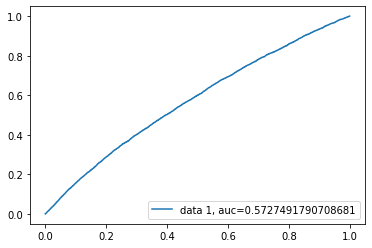

In [ ]:
y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# **KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
NN = KNeighborsClassifier(n_neighbors=7)
NN.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [ ]:
y_pred = NN.predict(X_test)
print("model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

model accuracy(in %): 91.61809295692747


# **RandomForestClassifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
 
 
x=df5.drop(["TARGET"],axis=1)
y=df5["TARGET"]
 
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=0)
 
base=RandomForestClassifier(n_estimators=1000)
base.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
from sklearn import metrics
y_pred=base.predict(X_test)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("f1_score:",metrics.f1_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))

[[66264     7]
 [ 5945    11]]
Accuracy: 0.9175931438381768
f1_score: 0.003682624707063944
Recall: 0.0018468770987239758


# **Considered columns with less than or equal to 60% nan values**


    Model                      Accuracy

---

    LogisticRegression         91.75

---

    KNeighborsClassifier       91.61

---

    RandomForestClassifier     91.75


---

    Decision Tree              84.70






